# Energy Per Bit to Noise PSD ($\frac{E_b}{N_0}$)

References:
+ https://en.wikipedia.org/wiki/Eb/N0
+ http://www.sss-mag.com/ebn0.html
+ https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

## Definition
+ From Wikipedia, accessed 8/20/2020

**$\frac{E_b}{N_0}$ (energy per bit to noise power spectral density ratio)** is a normalized signal-to-noise ratio (SNR) measure, also known as the **"SNR per bit"**. It is especially useful when comparing the bit error rate (BER) performance of different digital modulation schemes without taking bandwidth into account.

As the description implies, $E_b$ is the signal energy associated with each user data bit; it is equal to the signal power divided by the user bit rate (not the channel symbol rate). If signal power is in watts and bit rate is in bits per second, $E_b$ is in units of joules (watt-seconds). $N_0$ is the noise spectral density, the noise power in a 1 Hz bandwidth, measured in watts per hertz or joules.

These are the same units as $E_b$ so the ratio $\frac{E_b}{N_0}$ is dimensionless; it is frequently expressed in decibels (dB). $\frac{E_b}{N_0}$ directly indicates the power efficiency of the system without regard to modulation type, error correction coding or signal bandwidth (including any use of spread spectrum). This also avoids any confusion as to which of several definitions of "bandwidth" to apply to the signal.

## Computation

To convert between **SNR** (i.e., carrier to noise power ratio, $\frac{C}{N}$) and $\frac{E_b}{N_0}$, we need to know the **bit rate** and **channel bandwidth**.

$$
\frac{C}{N} = \frac{E_b}{N_0}\cdot \frac{f_b}{B}
$$

where $f_b$ is the bit rate (in bits per second), and $B$ is the channel bandwidth (in Hz).  So to convert from SNR to $\frac{E_b}{N_0}$:

$$
\frac{E_b}{N_0} = \frac{C}{N}\cdot \frac{B}{f_b}
$$

The "channel width" depends on the receiver--for simulating wideband signal environments to test DSP algorithms, I think the right answer is to use the full sample rate (i.e., bandwidth of the "receiver"). 

$$
N = C\cdot \frac{N_0}{E_b}\cdot \frac{B}{f_b}
$$

### Additive White Gaussian Noise
+ from https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

**SNR** is $\frac{P_{signal}}{P_{noise}}$, where it's important to keep in mind that $P$ is *average power*.

Or in dB: $P_{signal_{dB}} - P_{noise_{dB}}$

In this case, we already have a signal and we want to generate noise to give us a desired SNR.

While noise can come in different flavors depending on what you are modeling, a good start is **Additive White Gaussian Noise (AWGN)**. To model AWGN you need to add a zero-mean gaussian random variable to your original signal. The variance of that random variable will affect the average noise power.

For a Gaussian random variable $X$, the average power $E[X^2]$, also known as the **second moment**, is $E[X^2] = \mu^2 + \sigma^2$

So for white noise $\mu^2=0$, and the average power is then equal to the variance $\sigma^2$.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def gen_tone(amplitude, freq, samp_rate, N, phase=0, complex_valued=True):
    t = np.linspace(0, (N+1)/samp_rate, N)
    if complex_valued:
        return amplitude*np.exp(-1j*(2*np.pi*freq*t + phase))
    else:
        return np.real(amplitude*np.exp(-1j*(2*np.pi*freq*t + phase)))

def gen_gaussian_noise(power_rms2, N, complex_valued=True):
    # generate noise at average power (RMS^2) given
    if complex_valued:
        return np.sqrt(0.5 * power_rms2) * (np.random.randn(N) + 1j * np.random.randn(N))
    else:
        return np.sqrt(power_rms2) * (np.random.randn(N))

def add_awgn(signal, SNR_dB, verbose=False):
    assert len(signal) < 1e9 # let's not get carried away here...
    sig_power_rms2 = np.real(np.vdot(signal, signal))/len(signal) # avg power of input signal
    # NOTE: numpy.vdot() uses the complex conjugate of first argument, so the result of a*a is
    # the absolute square and has no imaginary component; np.real() is applied to change dtype
    noise_power_rms2 = np.power(10, -SNR_dB/10) * sig_power_rms2 # avg noise power (rms) which results in desired SNR
    if verbose:
        print("Signal Power (rms^2): {}".format(np.real(np.vdot(signal, signal))/len(signal)))
        print("Noise Power (rms^2): {}".format(noise_power_rms2))
    return signal + gen_gaussian_noise(noise_power_rms2, len(signal))

def add_awgn_EbNo(signal, EbNo_dB, bit_rate, channel_width):
    assert len(signal) < 1e9 # let's not get carried away here...
    sig_power = np.real(np.vdot(signal, signal))/len(signal)
    noise_power = sig_power*channel_width/(bit_rate*np.power(10, EbNo_dB/10))
    return signal + gen_gaussian_noise(noise_power, len(signal))

def compute_power_rms2(signal):
    # compute the average power (RMS^2) of the given signal
    return np.real(np.vdot(signal, signal))/len(signal)
    # NOTE: numpy.vdot() uses the complex conjugate of first argument, so the result of a*a is
    # the absolute square and has no imaginary component; np.real() is applied to change dtype

In [8]:
amp = 1.5
freq = 1e3
Fs = 20*freq
N = 4096

bit_rate = freq/4 # 4 carrier cycles per bit
channel_width = Fs # "channel width" is going to depend on the receiver.

tone = gen_tone(amp, freq, Fs, N, complex_valued=True)
tone_w_noise = add_awgn(tone, -3, verbose=True)
tone_w_noise_EbNo = add_awgn_EbNo(tone, 30, bit_rate, channel_width)

Signal Power (rms^2): 2.25
Noise Power (rms^2): 4.4893402086799785


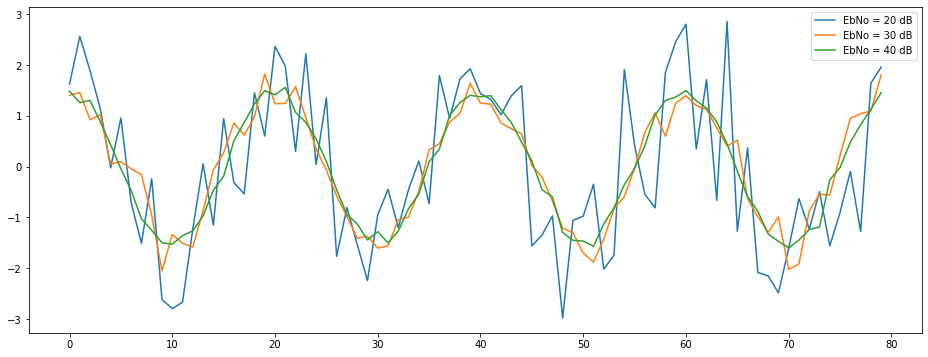

In [9]:
cycles = 4

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,6))
#plt.plot(np.real(tone[:int(cycles*Fs/freq)]))

EbNo = 20
for i in np.arange(0,3):
    plt.plot(np.real(add_awgn_EbNo(tone, EbNo+10*i, bit_rate, channel_width))[:int(cycles*Fs/freq)], label="EbNo = {} dB".format(EbNo + 10*i))
plt.legend()
plt.show()


### Additional Notes

To convert any ratio to dB use: $10log_{10}(\frac{numerator}{denominator})$

To convert from dB to linear: $10^{\frac{dB\space value}{10}}$